In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [6]:
df=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['parcelid','rawcensustractandblock']] 
df['state']=df['rawcensustractandblock'].map(lambda u: str(u)[:2])
df=df.drop('rawcensustractandblock',axis=1).compute()
df=df.set_index('parcelid')
df.shape

(9463187, 1)

In [7]:
df['state'].value_counts()

39    3111391
37    2932874
06    1809321
36     829379
19     732280
na      47942
Name: state, dtype: int64

In [8]:
df=df[df['state']=='06']
df.shape

(1809321, 1)

In [9]:
filename='tax_history_2007to2017_v2.parq'

In [10]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute().set_index("parcelid")

In [11]:
print data.shape
data=data.loc[df.index]
print data.shape

(84932226, 14)
(19030035, 14)


In [12]:
set(data.assessmentyear)

{2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}

In [13]:
years=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [14]:
data_dict={u:data[data['assessmentyear']==u] for u in 
           years}

In [15]:
for i in years:
    print i, data_dict[i].shape[0]

2007 1713386
2008 1727862
2009 1734818
2010 1774728
2011 1779611
2012 1784956
2013 1721960
2014 1382214
2015 1791937
2016 1809242
2017 1809321


In [16]:
lst=[]
for i in years:
    lst.append(data_dict[i].isnull().mean())
tmpdf=pd.concat(lst,axis=1)
tmpdf.columns=years
tmpdf

2007      2008      2009      2010      2011  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             1.000000  1.000000  1.000000  1.000000  1.000000   
improvementmarketvalue      1.000000  1.000000  1.000000  1.000000  1.000000   
structuretaxvaluedollarcnt  0.009994  0.009489  0.008016  0.008954  0.008160   
totalassessedvalue          0.002090  0.001762  0.001663  0.003002  0.002997   
taxamount                   0.978500  0.978564  0.978583  0.979018  0.979061   
taxvaluedollarcnt           0.002090  0.001762  0.001663  0.003002  0.002997   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.008034  0.007879  0.007920  0.007374  0.007398   
taxdelinquencyyear          0.999294  0.999122  0.999114  0.999300  0.999513   
totalmarketvalue            1.000000  1.000000  1.000000  1.000000  1.000000   
improvementassessedvalue    0.009994  0.009489  0.008016  0.008954  0.008160   
landtaxvaluedollarcnt       0.008034  0.007879  0.007920  0.007374  0.007398   
landmarketvalue             1.000000  1.000000  1.000000  1.000000  1.000000   

                                2012      2013      2014      2015      2016  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             1.000000  1.000000  1.000000  1.000000  1.000000   
improvementmarketvalue      1.000000  1.000000  1.000000  1.000000  1.000000   
structuretaxvaluedollarcnt  0.007976  0.007135  0.006708  0.006833  0.005371   
totalassessedvalue          0.003217  0.003597  0.003023  0.003368  0.003314   
taxamount                   0.979099  0.895114  0.026634  0.024539  0.011160   
taxvaluedollarcnt           0.003217  0.003597  0.003023  0.003368  0.003314   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.007665  0.009903  0.012713  0.010945  0.010872   
taxdelinquencyyear          0.999550  0.915640  0.989876  0.986590  0.987939   
totalmarketvalue            1.000000  1.000000  1.000000  1.000000  1.000000   
improvementassessedvalue    0.007976  0.007135  0.006708  0.006833  0.005371   
landtaxvaluedollarcnt       0.007665  0.009903  0.012713  0.010945  0.010872   
landmarketvalue             1.000000  1.000000  1.000000  1.000000  1.000000   

                                2017  
assessmentyear              0.000000  
taxratecodearea             1.000000  
improvementmarketvalue      1.000000  
structuretaxvaluedollarcnt  0.004671  
totalassessedvalue          0.003315  
taxamount                   0.021264  
taxvaluedollarcnt           0.003315  
edition                     0.000000  
landassessedvalue           0.010876  
taxdelinquencyyear          0.986698  
totalmarketvalue            1.000000  
improvementassessedvalue    0.004671  
landtaxvaluedollarcnt       0.010876  
landmarketvalue             1.000000

In [17]:
def get_col(col):
    df=pd.concat([data_dict[i][col] for i in years],axis=1)
    df.columns=years
    return df

In [18]:
print "Are there ones whose tax is not null but taxvalue is null?"
a=get_col("taxamount")
b=get_col("taxvaluedollarcnt")

Are there ones whose tax is not null but taxvalue is null?


In [19]:
for year in years:
    aa=a.loc[:,year]
    bb=b.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    num=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    print year,num,ab.shape[0],float(num)/ab.shape[0]
    #break

2007 2 1809321 1.10538704851e-06
2008 4 1809321 2.21077409702e-06
2009 4 1809321 2.21077409702e-06
2010 4 1809321 2.21077409702e-06
2011 7 1809321 3.86885466979e-06
2012 7 1809321 3.86885466979e-06
2013 50 1809321 2.76346762128e-05
2014 134 1809321 7.40609322503e-05
2015 112 1809321 6.19016747166e-05
2016 146 1809321 8.06932545413e-05
2017 108 1809321 5.96909006196e-05


In [20]:
print "how assesed values varies with market value?"
c=get_col('totalassessedvalue')
d=get_col('totalmarketvalue')

how assesed values varies with market value?


In [21]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
   
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 1709805 0 0 1713386 [ 0.998  0.     0.     0.002]
2008 1724818 0 0 1727862 [ 0.998  0.     0.     0.002]
2009 1731933 0 0 1734818 [ 0.998  0.     0.     0.002]
2010 1769400 0 0 1774728 [ 0.997  0.     0.     0.003]
2011 1774277 0 0 1779611 [ 0.997  0.     0.     0.003]
2012 1779213 0 0 1784956 [ 0.997  0.     0.     0.003]
2013 1715766 0 0 1721960 [ 0.996  0.     0.     0.004]
2014 1378035 0 0 1382214 [ 0.997  0.     0.     0.003]
2015 1785902 0 0 1791937 [ 0.997  0.     0.     0.003]
2016 1803246 0 0 1809242 [ 0.997  0.     0.     0.003]
2017 1803324 0 0 1809321 [ 0.997  0.     0.     0.003]


In [26]:
print "always acess value"

always acess value


In [22]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 
    

2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [27]:
print """
    almost missing 
"""


    almost missing 



In [28]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

look at their difference
2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [29]:
print """
    always missing
"""


    always missing



### landassessedvalue vs  landmarketvalue

In [30]:
print "how assesed values varies with market value?"
c=get_col('landassessedvalue')
d=get_col('landmarketvalue')

how assesed values varies with market value?


In [31]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 1699621 0 0 1713386 [ 0.992  0.     0.     0.008]
2008 1714249 0 0 1727862 [ 0.992  0.     0.     0.008]
2009 1721078 0 0 1734818 [ 0.992  0.     0.     0.008]
2010 1761641 0 0 1774728 [ 0.993  0.     0.     0.007]
2011 1766446 0 0 1779611 [ 0.993  0.     0.     0.007]
2012 1771275 0 0 1784956 [ 0.992  0.     0.     0.008]
2013 1704908 0 0 1721960 [ 0.99  0.    0.    0.01]
2014 1364642 0 0 1382214 [ 0.987  0.     0.     0.013]
2015 1772324 0 0 1791937 [ 0.989  0.     0.     0.011]
2016 1789572 0 0 1809242 [ 0.989  0.     0.     0.011]
2017 1789643 0 0 1809321 [ 0.989  0.     0.     0.011]


In [32]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [33]:
print """
    always missing 
"""


    always missing 



In [34]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

look at their difference
2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [35]:
print """
    always missing
"""


    always missing



### landassessedvalue vs  landmarketvalue

In [36]:
print "how assesed values varies with market value?"
c=get_col('improvementassessedvalue')
d=get_col('improvementmarketvalue')

how assesed values varies with market value?


In [37]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 1696263 0 0 1713386 [ 0.99  0.    0.    0.01]
2008 1711466 0 0 1727862 [ 0.991  0.     0.     0.009]
2009 1720912 0 0 1734818 [ 0.992  0.     0.     0.008]
2010 1758837 0 0 1774728 [ 0.991  0.     0.     0.009]
2011 1765089 0 0 1779611 [ 0.992  0.     0.     0.008]
2012 1770719 0 0 1784956 [ 0.992  0.     0.     0.008]
2013 1709674 0 0 1721960 [ 0.993  0.     0.     0.007]
2014 1372942 0 0 1382214 [ 0.993  0.     0.     0.007]
2015 1779692 0 0 1791937 [ 0.993  0.     0.     0.007]
2016 1799525 0 0 1809242 [ 0.995  0.     0.     0.005]
2017 1800869 0 0 1809321 [ 0.995  0.     0.     0.005]


In [38]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [39]:
print """
    always missing
"""


    always missing



In [40]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

look at their difference
2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [41]:
print """
   always missing
"""


   always missing



### land vs total

In [42]:
c=get_col('improvementassessedvalue')
d=get_col('landassessedvalue')

In [43]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 10155 13513 1686108 1713386 [ 0.006  0.008  0.984  0.002]
2008 10538 13321 1700928 1727862 [ 0.006  0.008  0.984  0.002]
2009 10836 11002 1710076 1734818 [ 0.006  0.006  0.986  0.002]
2010 7736 10540 1751101 1774728 [ 0.004  0.006  0.987  0.003]
2011 7807 9164 1757282 1779611 [ 0.004  0.005  0.987  0.003]
2012 7910 8466 1762809 1784956 [ 0.004  0.005  0.988  0.003]
2013 10858 6092 1698816 1721960 [ 0.006  0.004  0.987  0.004]
2014 13393 5093 1359549 1382214 [ 0.01   0.004  0.984  0.003]
2015 13578 6210 1766114 1791937 [ 0.008  0.003  0.986  0.003]
2016 13674 3721 1785851 1809242 [ 0.008  0.002  0.987  0.003]
2017 13681 2455 1787188 1809321 [ 0.008  0.001  0.988  0.003]


In [44]:
print "most of them are null consistent   "

most of them are null consistent   


look at their ratio
2007 1686108 [ 0.984] 0.0 0.0


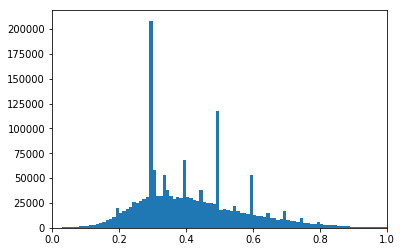

2008 1700928 [ 0.984] 0.0 0.0


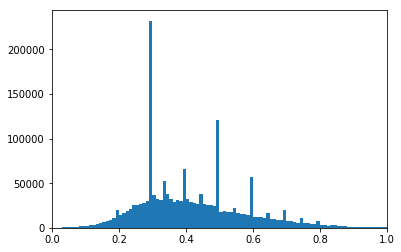

2009 1710076 [ 0.986] 0.0 0.0


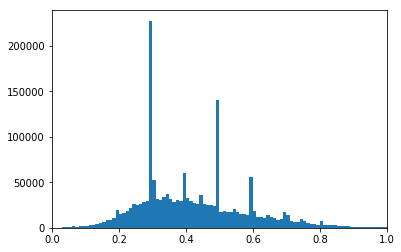

2010 1751101 [ 0.987] 0.0 0.0


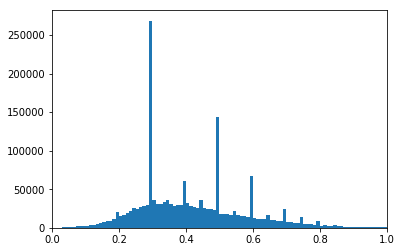

2011 1757282 [ 0.987] 0.0 0.0


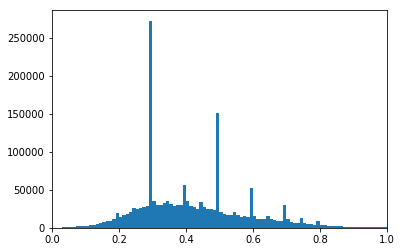

2012 1762809 [ 0.988] 0.0 0.0


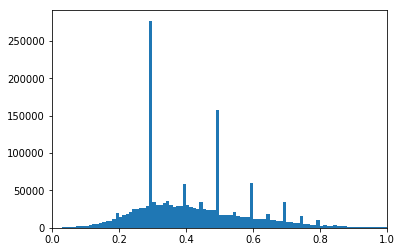

2013 1698816 [ 0.987] 0.0 0.0


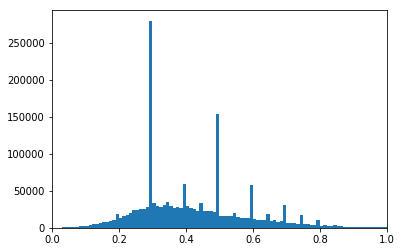

2014 1359549 [ 0.984] 0.0 0.0


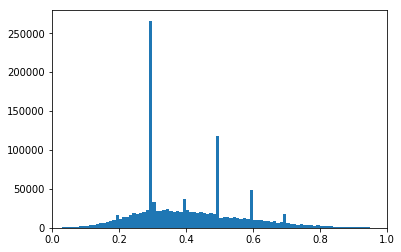

2015 1766114 [ 0.986] 0.0 0.0


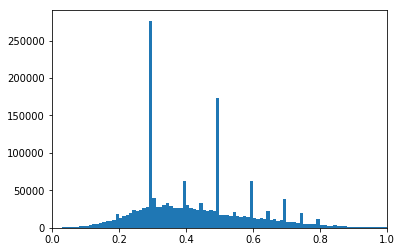

2016 1785851 [ 0.987] 0.0 0.0


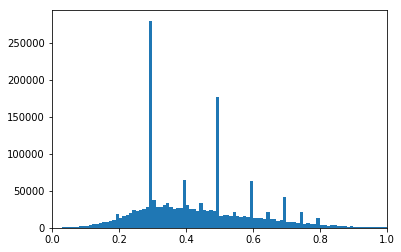

2017 1787188 [ 0.988] 0.0 0.0


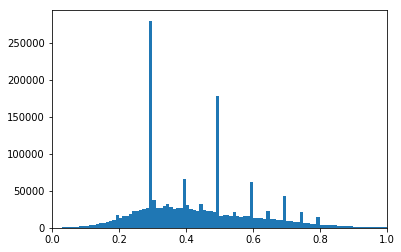

In [45]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [46]:
print """
   good shape
"""


   good shape



### land vs total

In [47]:
c=get_col(u'improvementmarketvalue')
d=get_col(u'landmarketvalue')

In [48]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue       
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 0 0 0 1713386 [ 0.  0.  0.  1.]
2008 0 0 0 1727862 [ 0.  0.  0.  1.]
2009 0 0 0 1734818 [ 0.  0.  0.  1.]
2010 0 0 0 1774728 [ 0.  0.  0.  1.]
2011 0 0 0 1779611 [ 0.  0.  0.  1.]
2012 0 0 0 1784956 [ 0.  0.  0.  1.]
2013 0 0 0 1721960 [ 0.  0.  0.  1.]
2014 0 0 0 1382214 [ 0.  0.  0.  1.]
2015 0 0 0 1791937 [ 0.  0.  0.  1.]
2016 0 0 0 1809242 [ 0.  0.  0.  1.]
2017 0 0 0 1809321 [ 0.  0.  0.  1.]


In [49]:
print "most of them are null consistent   "

most of them are null consistent   


In [50]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue       
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

look at their ratio
2007 missing
2008 missing
2009 missing
2010 missing
2011 missing
2012 missing
2013 missing
2014 missing
2015 missing
2016 missing
2017 missing


In [51]:
print """
    always missing
"""


    always missing

